In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import bp_decoder, bposd_decoder
import time
from src.build_SHYPS_circuit import build_SHYPS_circuit
from src.build_circuit import dem_to_check_matrices
from src.codes_q import create_bivariate_bicycle_codes 
from src.utils import edge_coloring_bipartite
# from src import osd_window

1.13.0


[[1 0 1 1 0 0 0]
 [0 1 0 1 1 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1]
 [1 0 0 0 1 0 1]
 [1 1 0 0 0 1 0]
 [0 1 1 0 0 0 1]]
[[1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0]
 [0 0 1 0 1 1 1]]
color=0, #edges: 49
color=1, #edges: 49
color=2, #edges: 49
check matrix shape (105, 833), max (row, column) weight (44, 9), min (row, column) weight (28, 2)
obs matrix shape (9, 833), nnz=624


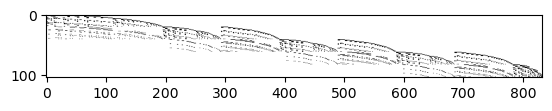

In [18]:
r = 3
circuit = build_SHYPS_circuit(r=r, p=0.001, num_repeat=4)
dem = circuit.detector_error_model()
chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
chk_row_wt = np.sum(chk, axis=1)
chk_col_wt = np.sum(chk, axis=0)
num_row, num_col = chk.shape
print(f"check matrix shape {chk.shape}, max (row, column) weight ({np.max(chk_row_wt)}, {np.max(chk_col_wt)}),",
      f"min (row, column) weight ({np.min(chk_row_wt)}, {np.min(chk_col_wt)})")
print(f"obs matrix shape {obs.shape}, nnz={obs.sum()}")
plt.imshow(chk.toarray(), cmap="gist_yarg")


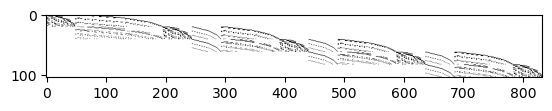

In [21]:
num_det = r * (2**r-1) # number of detectors
lower_bounds = []
upper_bounds = []
i = 0
while i < num_row:
    lower_bounds.append(i)
    upper_bounds.append(i+num_det)
    if i+num_det > num_row:
        break
    lower_bounds.append(i)
    upper_bounds.append(i+2*num_det)
    i += num_det
    
region_dict = {}
for i, (l,u) in enumerate(zip(lower_bounds, upper_bounds)):
    region_dict[(l,u)] = i

region_cols = [[] for _ in range(len(region_dict))]

for i in range(num_col):
    nnz_col = np.nonzero(chk[:,i])[0]
    l = nnz_col.min() // num_det * num_det
    u = (nnz_col.max() // num_det + 1) * num_det
    region_cols[region_dict[(l,u)]].append(i)  

chk = np.concatenate([chk[:,col].toarray() for col in region_cols], axis=1)
obs = np.concatenate([obs[:,col].toarray() for col in region_cols], axis=1)
priors = np.concatenate([priors[col] for col in region_cols])
plt.imshow(chk, cmap="gist_yarg")

In [11]:
def decode(p, num_repeat, num_shots=10000, osd_order=10):  # whether use my heuristic OSD on shortened PCM)
    circuit = build_SHYPS_circuit(3, p, num_repeat)
    dem = circuit.detector_error_model()
    # print(dem)
    chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
    chk_row_wt = np.sum(chk, axis=1)
    chk_col_wt = np.sum(chk, axis=0)
    print(f"check matrix shape {chk.shape}, max (row, column) weight ({np.max(chk_row_wt)}, {np.max(chk_col_wt)}),",
        f"min (row, column) weight ({np.min(chk_row_wt)}, {np.min(chk_col_wt)})")
    bpd = bposd_decoder(
        chk, # the parity check matrix
        error_rate=p, # does not matter as channel_prob is set
        channel_probs=priors, # assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=1000, # the maximum number of iterations for BP
        bp_method="minimum_sum", # messages are not clipped, may have numerical issues
        ms_scaling_factor=1.0, # min sum scaling factor. If set to zero the variable scaling factor method is used
        osd_method="osd_cs", # the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        osd_order=osd_order, # the osd search depth, not specified in [1]
    )


    start_time = time.perf_counter()
    dem_sampler: stim.CompiledDemSampler = dem.compile_sampler()
    det_data, obs_data, err_data = dem_sampler.sample(shots=num_shots, return_errors=False, bit_packed=False)
    print("detector data shape", det_data.shape)
    print("observable data shape", obs_data.shape)
    end_time = time.perf_counter()
    print(f"Stim: noise sampling for {num_shots} shots, elapsed time:", end_time-start_time)
    num_err = 0
    num_flag_err = 0
    start_time = time.perf_counter()
    for i in range(num_shots):
        e_hat = bpd.decode(det_data[i])
        num_flag_err += ((chk @ e_hat + det_data[i]) % 2).any()
        ans = (obs @ e_hat + obs_data[i]) % 2
        num_err += ans.any()
    end_time = time.perf_counter()
    print("Elapsed time:", end_time-start_time)
    print(f"Flagged Errors: {num_flag_err}/{num_shots}") # expect 0 for OSD
    print(f"Logical Errors: {num_err}/{num_shots}")
    p_l = num_err / num_shots
    p_l_per_round = 1-(1-p_l) ** (1/num_repeat)
    print("Logical error per round:", p_l_per_round)

In [13]:
decode(p=0.001, num_repeat=4, num_shots=10000, osd_order=0)

[[1 0 1 1 0 0 0]
 [0 1 0 1 1 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1]
 [1 0 0 0 1 0 1]
 [1 1 0 0 0 1 0]
 [0 1 1 0 0 0 1]]
[[1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0]
 [0 0 1 0 1 1 1]]
color=0, #edges: 49
color=1, #edges: 49
color=2, #edges: 49
check matrix shape (105, 833), max (row, column) weight (44, 9), min (row, column) weight (28, 2)
detector data shape (10000, 105)
observable data shape (10000, 9)
Stim: noise sampling for 10000 shots, elapsed time: 0.0017696951981633902
Elapsed time: 17.436129166046157
Flagged Errors: 0/10000
Logical Errors: 57/10000
Logical error per round: 0.0014280561051007723
